# Imports

In [1]:
from os import walk

import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import skimage.transform
import tensorflow.keras as keras
from keras import layers, losses, optimizers
from keras.callbacks import CSVLogger
from keras.callbacks.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
proj_dir = 'drive/My Drive/DS8013-Project/'
data_dir = proj_dir + 'data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [0]:
def shuffle_data(x, r):
    """
    Shuffles x and r in the same manner.
    
    :return x and r shuffled in the same manner.
    """
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    
    return x[idx], r[idx]

In [4]:
trn = pd.read_pickle(data_dir + 'train.pickle')
val = pd.read_pickle(data_dir + 'valid.pickle')
tst = pd.read_pickle(data_dir + 'test.pickle')

x_trn, y_trn = shuffle_data(trn['features'], trn['labels'])
x_val, y_val = shuffle_data(val['features'], val['labels'])
x_test, y_test = shuffle_data(tst['features'], tst['labels'])
num_classes = len(set(y_trn))

print('Train Shapes:', x_trn.shape, y_trn.shape)
print('Validation Shapes:', x_val.shape, y_val.shape)
print('Test Shapes:', x_test.shape, y_test.shape)

Train Shapes: (34799, 32, 32, 3) (34799,)
Validation Shapes: (4410, 32, 32, 3) (4410,)
Test Shapes: (12630, 32, 32, 3) (12630,)


In [5]:
# Loading Google Maps images for testing.
targets = pd.read_csv(proj_dir + 'targets.csv', sep=', ')
targets = dict(targets.values)

x_maps = []
y_maps = []
maps_images_path = proj_dir + 'tests/'
files = list(walk(maps_images_path))[0][2]

for file in files:
    map_img = PIL.Image.open(maps_images_path + file)
    map_img = np.asarray(map_img.convert('RGB'))
    map_img = skimage.transform.resize(map_img, x_trn.shape[1:], mode='wrap')
    x_maps.append(map_img)
    filename = file.split('.')[0]
    y_maps.append(targets[filename.lower()])

x_maps = np.array(x_maps)
x_maps.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


(215, 32, 32, 3)

In [6]:
print('train max:', np.max(x_trn))
print('validation max:', np.max(x_val))
print('test max:', np.max(x_test))
print('maps max:', np.max(x_maps))

train max: 255
validation max: 255
test max: 255
maps max: 1.0


In [0]:
# Normalizing data:
x_trn = x_trn.astype(np.uint8) / 255
x_val = x_val.astype(np.uint8) / 255
x_test = x_test.astype(np.uint8) / 255

In [8]:
# Vectorized data for models other than CNN.
x_trn_vectorized = x_trn.reshape(x_trn.shape[0], -1)
x_val_vectorized = x_val.reshape(x_val.shape[0], -1)
x_test_vectorized = x_test.reshape(x_test.shape[0], -1)
x_maps_vectorized = x_maps.reshape(x_maps.shape[0], -1)

x_trn_vectorized.shape

(34799, 3072)

In [9]:
encoder = OneHotEncoder(categories='auto')   
y_trn_encoded = encoder.fit_transform(y_trn.reshape((-1, 1))).toarray()
y_val_encoded = encoder.transform(y_val.reshape((-1, 1))).toarray()
y_test_encoded = encoder.transform(y_test.reshape((-1, 1))).toarray()

y_trn_encoded.shape

(34799, 43)

In [10]:
labels = pd.read_csv(proj_dir + 'label_names.csv', 
                     index_col='ClassId')
print(labels)
labels = list(labels.values.flatten())

                                                  SignName
ClassId                                                   
0                                     Speed limit (20km/h)
1                                     Speed limit (30km/h)
2                                     Speed limit (50km/h)
3                                     Speed limit (60km/h)
4                                     Speed limit (70km/h)
5                                     Speed limit (80km/h)
6                              End of speed limit (80km/h)
7                                    Speed limit (100km/h)
8                                    Speed limit (120km/h)
9                                               No passing
10            No passing for vehicles over 3.5 metric tons
11                   Right-of-way at the next intersection
12                                           Priority road
13                                                   Yield
14                                                    St

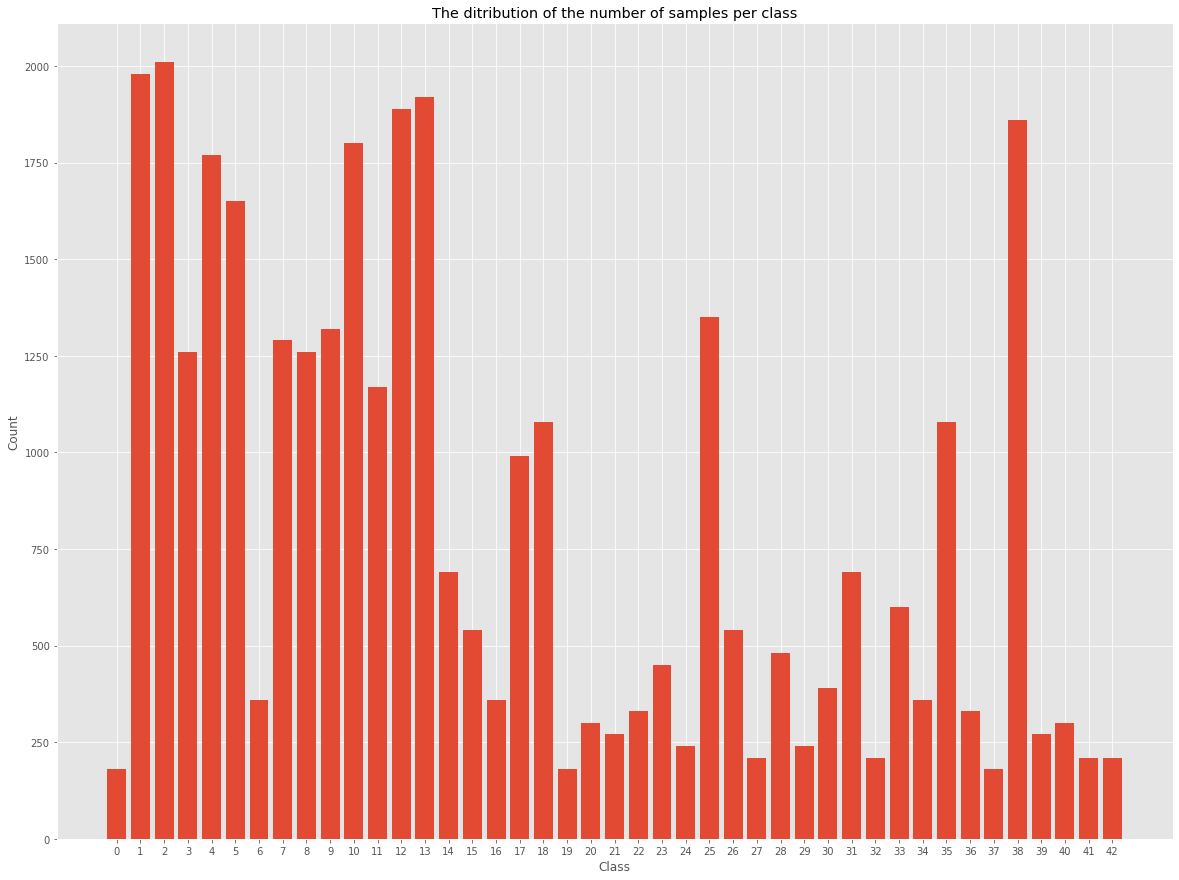

In [11]:
# Visualizing the distribution of the number of samples per class to ensure all
# classes have around the same number of samples.
y_values = sorted(np.unique(y_trn))
bars = [np.sum(y_trn == yval) for yval in y_values]

plt.figure(figsize=(20, 15))
plt.bar(y_values, bars, tick_label=y_values)
plt.ylabel("Count")
plt.xlabel("Class")
# plt.xticks(rotation=90)
plt.title("The ditribution of the number of samples per class")
plt.show()

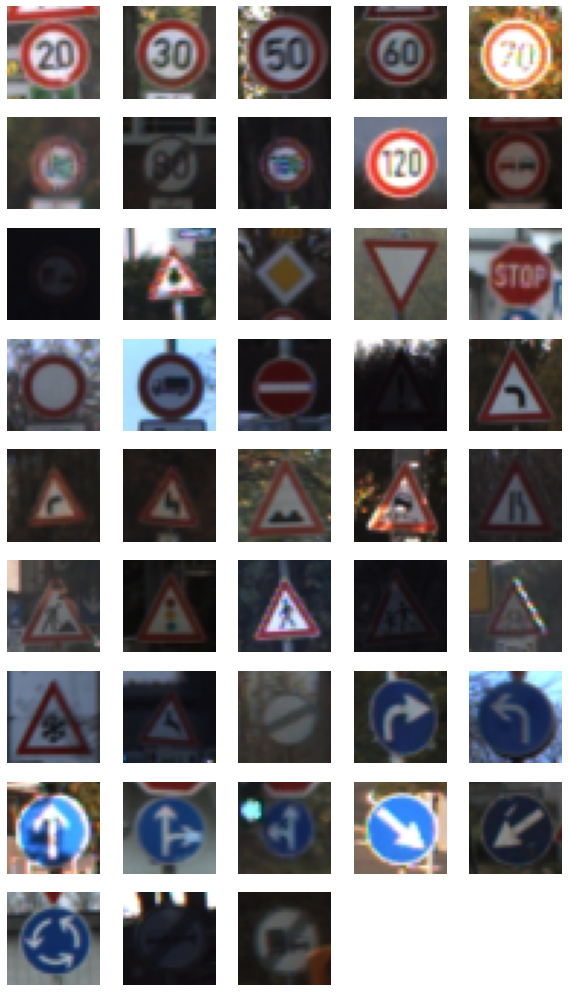

In [12]:
# Visualizing the training set.
size = (9, 5)
_, axs = plt.subplots(*size, figsize=(10, 18))
axs = axs.flatten()

for i in range(num_classes):
    axs[i].imshow(x_trn[y_trn == i][0].reshape(x_trn.shape[1:]))
    axs[i].axis('off')
for i in range(num_classes, size[0] * size[1]):
    axs[i].remove()

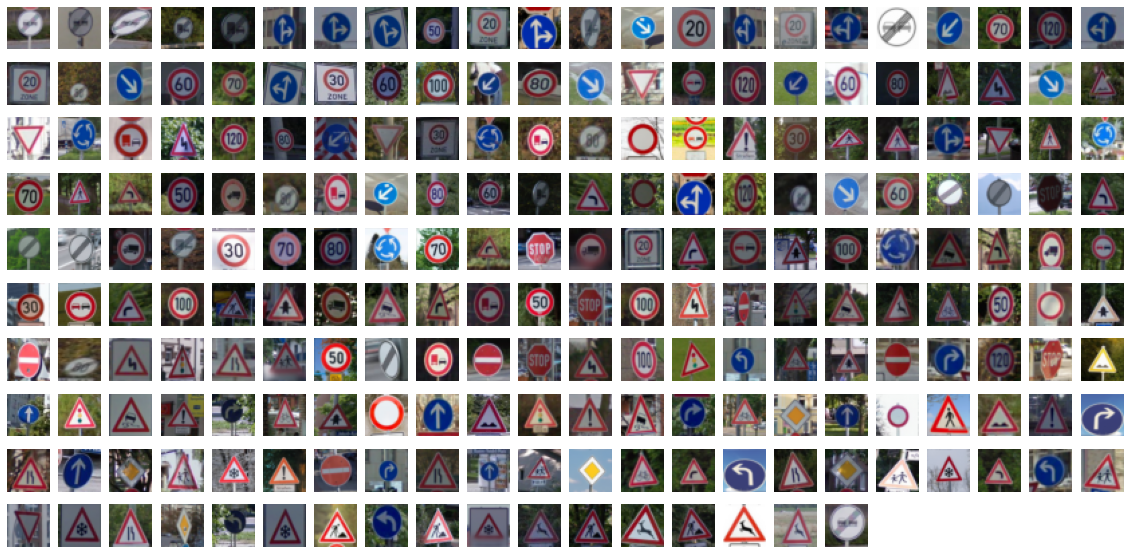

In [13]:
# Visualizing the Goole Maps images.
nrows, ncols = 10, 22
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axs = axs.flatten()
for i in range(x_maps.shape[0]):
    axs[i].imshow(x_maps[i].reshape(x_maps.shape[1:]))
    axs[i].axis('off')
for i in range(x_maps.shape[0], nrows * ncols):
    axs[i].remove()

plt.show()

In [0]:
"""
Creating a data batch generator that balances and performs image augmentation 
  on each batch.
Reference: https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-
           to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9
Reference: https://keras.io/preprocessing/image/
"""
def my_generator(x_data, y_data, gen_args, vectorize=False, batch_size=32):

    def generate():
        aug_gen = ImageDataGenerator(**gen_args)
        aug_gen.fit(x_trn)
        generator = aug_gen.flow(x_trn, y_trn_encoded, batch_size=batch_size)
        
        for x_batch, y_batch in generator:
            if vectorize:
                x_batch = x_batch.reshape(x_batch.shape[0], -1)
            yield x_batch, y_batch

    classes = np.unique(y_trn)
    weights = compute_class_weight("balanced", classes, y_trn)
    weights = {classes[i]: weights[i] for i in range(len(classes))}

    return generate(), weights

# Models

In [0]:
"""
Defining some functions for visualization of the results.
"""
def plot_accuracy(model_out):
    """
    Plots the accuracy vs. epoch of a model given the output of its fit 
        function.
    
    :param model_out: The output of the fit function of the model.
    """
    trn_accs = model_out['accuracy']
    val_accs = model_out['val_accuracy']
    epochs = np.arange(len(trn_accs))

    plt.figure(figsize=(15, 5))
    plt.plot(trn_accs)
    plt.plot(val_accs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.xticks(ticks=epochs, labels=epochs + 1)
    plt.legend(['Training', 'Validation'])

    plt.show()

def plot_loss(model_out):
    """
    Plots the loss vs. epoch of a model given the output of its fit 
        function.
    
    :param model_out: The output of the fit function of the model.
    """
    trn_accs = model_out['loss']
    val_accs = model_out['val_loss']
    epochs = np.arange(len(trn_accs))

    plt.figure(figsize=(15, 5))
    plt.plot(trn_accs)
    plt.plot(val_accs)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.xticks(ticks=epochs, labels=epochs + 1)
    plt.legend(['Training', 'Validation'])

    plt.show()

def plot_precision_recall(targets, preds):
    """
    Plots the precision and recall of a model per class.
    
    :param targets: The target values.
    :param preds: The predicted values.
    """
    acc = accuracy_score(targets, preds)
    print('Accuracy:', acc)

    # Check whether we are predicting class labels or indices.
    if preds[0] in labels:
        labs = [i for i in labels if i in preds or i in targets]
        x = [labels.index(i) for i in labs]
    else:
        labs = [labels.index(i) for i in labels if 
                labels.index(i) in preds or labels.index(i) in targets]
        x = labs

    recalls = recall_score(targets, preds, average=None, labels=labs)
    precisions = precision_score(targets, preds, average=None, labels=labs)

    df = pd.DataFrame(np.c_[x, recalls, precisions], 
                    columns=['labels', 'Recalls', 'Precisions'])
    df['labels'] = df['labels'].astype(int)
    df = df.melt(id_vars='labels')


    plt.figure(figsize=(15, 5))
    sb.barplot(x='labels', y='value', hue='variable', data=df)
    plt.legend(loc='lower right')
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.title("The precision and recall on each class")
    plt.show()

def plot_wrong_predictions_heatmap(targets, preds):
    """
    Plots a heatmap of the number of wrong prediction per pair of classes.
    
    :param targets: The target values.
    :param preds: The predicted values.
    """
    if preds[0] in labels:
        targets = [labels.index(i) for i in targets]
        preds = [labels.index(i) for i in preds]

    pred_table = pd.DataFrame(
        np.c_[targets, preds], columns=['Real', 'Prediction'])
    pred_table = pred_table[pred_table['Real'] != pred_table['Prediction']]
    hm_matrix = pd.crosstab(pred_table['Real'], pred_table['Prediction'])

    max_tick = hm_matrix.values.max() + 1
    ticks=np.arange(0, max_tick, np.ceil(max_tick / 10))
    boundaries = np.arange(-0.5, max_tick)
    cmap = plt.get_cmap("Reds", max_tick)
    
    plt.figure(figsize=(12, 10))
    ax = sb.heatmap(hm_matrix, annot=True, linewidths=0.01, 
                    cmap=cmap, linecolor='k',
                    cbar_kws={"ticks":ticks, "boundaries":boundaries})
    ax.set_title("Number of wrong predictions for each pair of target and " +
                 "predicted values")

    plt.tight_layout()
    plt.show()

## Convolutional Neural Network

In [0]:
# Whether to retrain the model or load a previously saved model.
retrain_cnn = False
cp_dir = proj_dir + 'models/cnn_best.hdf5'
log_dir = proj_dir + 'models/cnn_log.csv'

In [17]:
# Creating the model.
if retrain_cnn:
    n_filters = 128

    keras.backend.clear_session()
    cnn_model = Sequential()

    # First convolution layer:
    cnn_model.add(layers.Conv2D(n_filters, kernel_size=(5, 5), strides=(2, 2), 
                                activation='relu', padding="same", 
                                input_shape=x_trn.shape[1:]))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(layers.Dropout(0.1))
    cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    # Second convolution layer:
    cnn_model.add(layers.Conv2D(n_filters, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding="valid"))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(layers.Dropout(0.1))
    cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    # Third convolution layer:
    cnn_model.add(layers.Conv2D(n_filters * 2, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding="valid"))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(layers.Dropout(0.1))
    cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    # Fourth convolution layer:
    cnn_model.add(layers.Conv2D(n_filters * 2, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding="valid"))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(layers.Dropout(0.1))
    cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

    # Flatten
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dropout(0.2))

    # First dense layer:
    cnn_model.add(layers.Dense(512, activation='relu'))
    cnn_model.add(layers.Dropout(0.2))

    # Second dense layer:
    cnn_model.add(layers.Dense(1028, activation='relu'))
    cnn_model.add(layers.Dropout(0.2))

    # Output layer:
    cnn_model.add(layers.Dense(num_classes, activation="softmax"))

    # Compile the model
    cnn_model.compile(loss=losses.categorical_crossentropy, 
                    optimizer=optimizers.Adam(lr=0.0001), 
                    metrics=["accuracy"])

    cnn_model.summary()
else:
    best_cnn = load_model(cp_dir)
    best_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 128)       9728      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 128)       512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 128)      

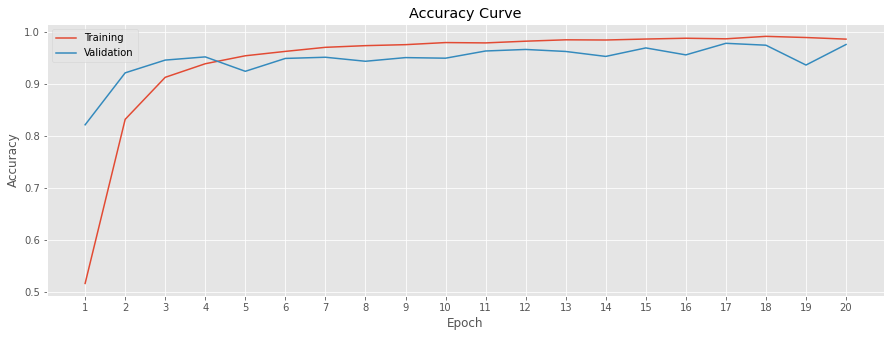

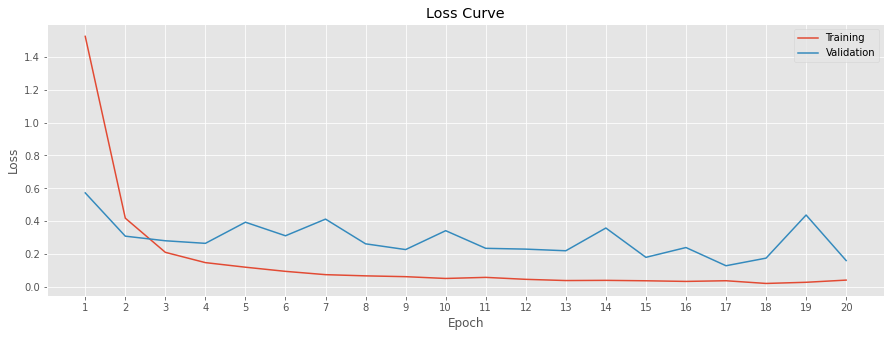

In [18]:
# Fitting the model on the custom generator.
if retrain_cnn:
    # Defining paramters for image augmentation:
    generator_args = {'width_shift_range': 0.1,
                      'height_shift_range': 0.1,
                      'zoom_range': 0.2,
                      'shear_range': 0.1,
                      'rotation_range': 30}
    generator, weights = my_generator(x_trn, y_trn_encoded, generator_args, 
                                      batch_size=64)
     # Save model logs and the best model to a file.
    model_log = CSVLogger(log_dir, separator=',') 
    model_cp = ModelCheckpoint(cp_dir, save_best_only=True,
                               monitor='val_loss', mode='min')

    # Fit the model.
    cnn_model.fit(x=generator, 
                  validation_data=(x_val, y_val_encoded),
                  epochs=20,
                  class_weight=weights,
                  steps_per_epoch=1000,
                  callbacks=[model_cp, model_log])
    best_cnn = load_model(cp_dir)  # Retrieve the best model.

out = pd.read_csv(log_dir, delimiter=',')
plot_accuracy(out)
plot_loss(out)

In [19]:
# Training accuracy:
y_trn_preds = best_cnn.predict_classes(x_trn)
print('Training Accuracy:', accuracy_score(y_trn, y_trn_preds))

Training Accuracy: 0.9994540072990603


In [20]:
# Validation accuracy:
y_preds = best_cnn.predict_classes(x_val)
print('Validation Accuracy:', accuracy_score(y_val, y_preds))

Validation Accuracy: 0.9773242630385488


Accuracy: 0.957957244655582


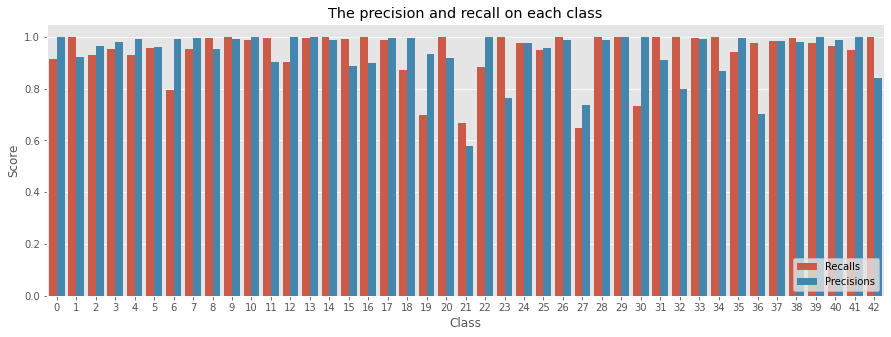

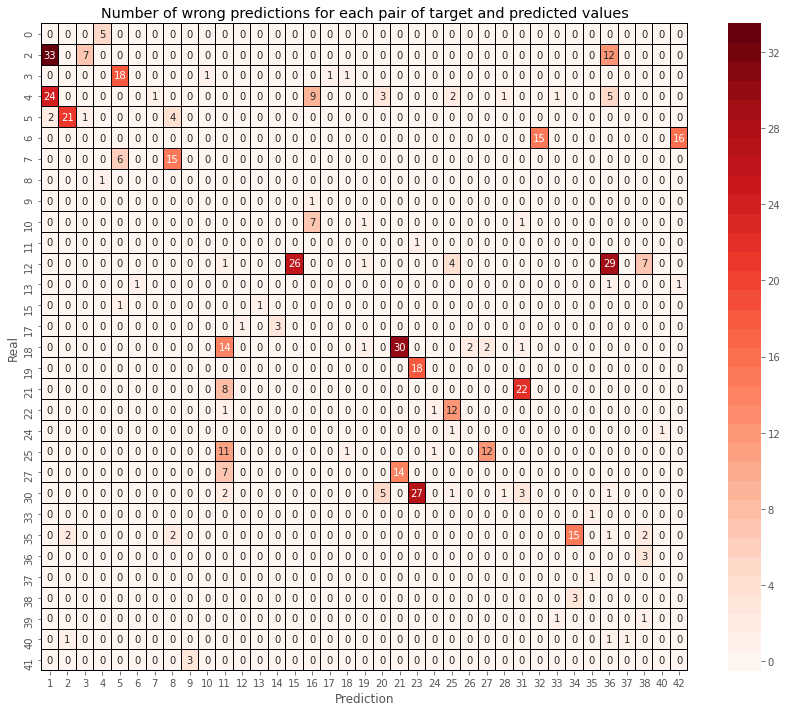

In [21]:
# Test scores:
y_preds = best_cnn.predict_classes(x_test)
plot_precision_recall(y_test, y_preds)
plot_wrong_predictions_heatmap(y_test, y_preds)

In [22]:
y_maps_probs = best_cnn.predict(x_maps)
y_maps_preds_idx = np.argmax(y_maps_probs, axis=1)
y_maps_preds = np.array(labels)[y_maps_preds_idx]
print('Accuracy:', accuracy_score(y_maps, y_maps_preds))

# Creating a table of target and predicted values:
idx = [int(file.split('.')[0].split('test')[1]) for file in files]
pred_table = pd.DataFrame(
    np.c_[y_maps, y_maps_preds, np.round(np.max(y_maps_probs, axis=1), 3)],
    columns=['Real', 'Prediction', 'Probability'], index=idx)

def style(r):
    color = 'orange' if r['Real'] != r['Prediction'] else 'lightblue'
    return [f'background-color: {color}'] * len(r.values)

pred_table = pred_table.sort_index().style.apply(style, axis=1)
display(pred_table)

Accuracy: 0.9813953488372092


,Real,Prediction,Probability
1,Speed limit (20km/h),Speed limit (20km/h),1.0
2,Speed limit (20km/h),Speed limit (20km/h),1.0
3,Speed limit (20km/h),Speed limit (20km/h),0.762
4,Speed limit (20km/h),Speed limit (20km/h),1.0
5,Speed limit (20km/h),Speed limit (20km/h),0.981
6,Speed limit (30km/h),Speed limit (30km/h),1.0
7,Speed limit (30km/h),Speed limit (30km/h),1.0
8,Speed limit (30km/h),Speed limit (30km/h),1.0
9,Speed limit (30km/h),Speed limit (30km/h),1.0
10,Speed limit (30km/h),Speed limit (30km/h),0.994


Accuracy: 0.9813953488372092


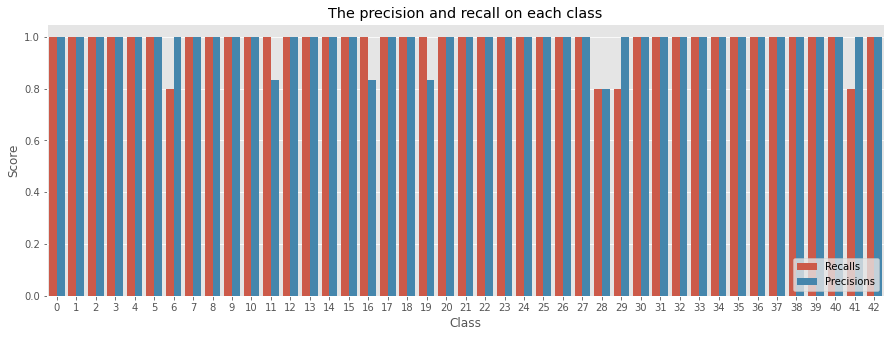

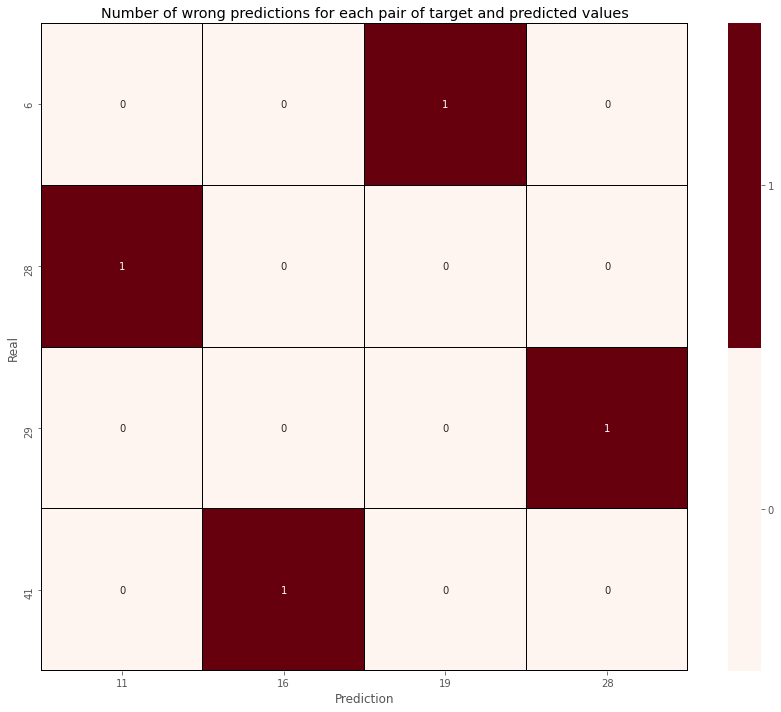

In [23]:
plot_precision_recall(y_maps, y_maps_preds)
plot_wrong_predictions_heatmap(y_maps, y_maps_preds)

## Artificial Neural Network

In [0]:
retrain_ann = False
cp_dir = proj_dir + 'models/ann_best.hdf5'
log_dir = proj_dir + 'models/ann_log.csv'

In [25]:
# Creating the ANN model.
if retrain_ann:
    keras.backend.clear_session()
    ann_model = Sequential()

    # First dense layer.
    ann_model.add(layers.Dense(128, activation='tanh',
                            input_shape=x_trn_vectorized.shape[1:]))
    ann_model.add(layers.BatchNormalization())

    # Second dense layer.
    ann_model.add(layers.Dense(128, activation='tanh'))
    ann_model.add(layers.BatchNormalization())
    ann_model.add(layers.Dropout(0.2)) 

    # Third dense layer.
    ann_model.add(layers.Dense(256, activation='tanh'))
    ann_model.add(layers.BatchNormalization())
    ann_model.add(layers.Dropout(0.2)) 

    # Fourth dense layer.
    ann_model.add(layers.Dense(512, activation='tanh'))
    ann_model.add(layers.BatchNormalization())
    ann_model.add(layers.Dropout(0.2)) 

    # Fifth dense layer.
    ann_model.add(layers.Dense(512, activation='tanh'))
    ann_model.add(layers.BatchNormalization())
    
    # Output layer with softmax activation
    ann_model.add(layers.Dense(y_trn_encoded.shape[1], activation="softmax"))

    # Compile the model
    ann_model.compile(loss=losses.categorical_crossentropy, 
                optimizer=optimizers.Adam(lr=0.0001), 
                metrics=["accuracy"])

    ann_model.summary()
else:
    best_ann = load_model(cp_dir)
    best_ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               393344    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)              

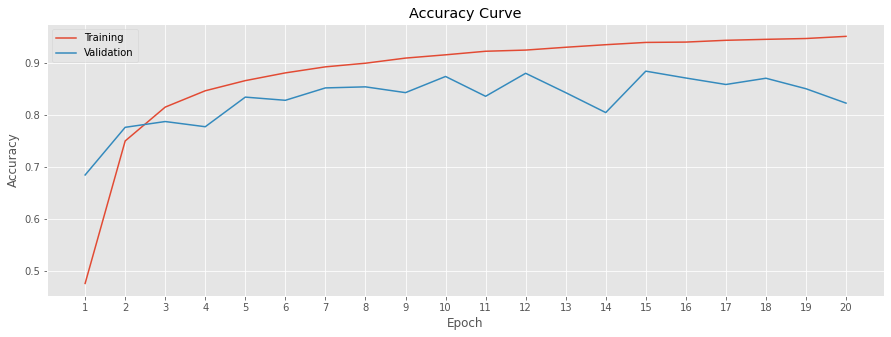

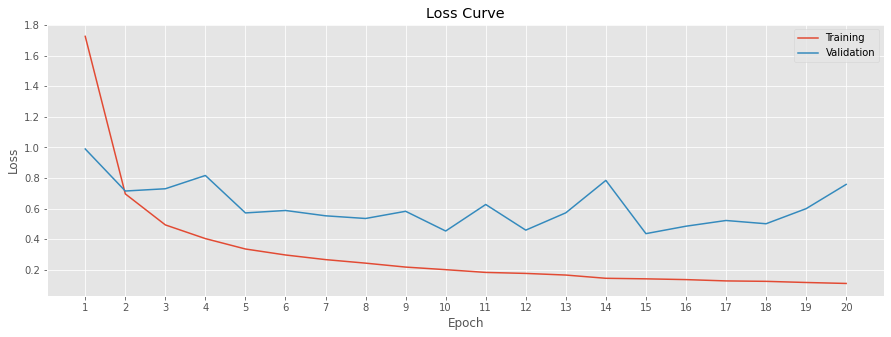

In [26]:
# Reference: https://stackoverflow.com/questions/38445982/how-to-log-keras-loss-
#            output-to-a-file
# Fitting the model on the custom generator.
if retrain_ann:
    generator_args = {'zoom_range': 0.1,
                      'shear_range': 0.1,
                      'rotation_range': 10}
    generator, weights = my_generator(x_trn, y_trn_encoded, generator_args,
                                      batch_size=64, vectorize=True)

    model_log = CSVLogger(log_dir, separator=',')
    model_cp = ModelCheckpoint(cp_dir, save_best_only=True,
                               monitor='val_loss', mode='min')
    ann_model.fit(x=generator, 
                  validation_data=(x_val_vectorized, y_val_encoded),
                  epochs=20,
                  class_weight=weights,
                  steps_per_epoch=1000,
                  callbacks=[model_cp, model_log])

best_ann = load_model(cp_dir)

out = pd.read_csv(log_dir, delimiter=',')
plot_accuracy(out)
plot_loss(out)

In [27]:
# Training accuracy:
y_trn_preds = best_ann.predict_classes(x_trn_vectorized)
print('Training Accuracy:', accuracy_score(y_trn, y_trn_preds))

Training Accuracy: 0.9678151671025029


In [28]:
# Validation accuracy:
y_preds = best_ann.predict_classes(x_val_vectorized)
print('Validation Accuracy:', accuracy_score(y_val, y_preds))

Validation Accuracy: 0.8841269841269841


Accuracy: 0.8577988915281077


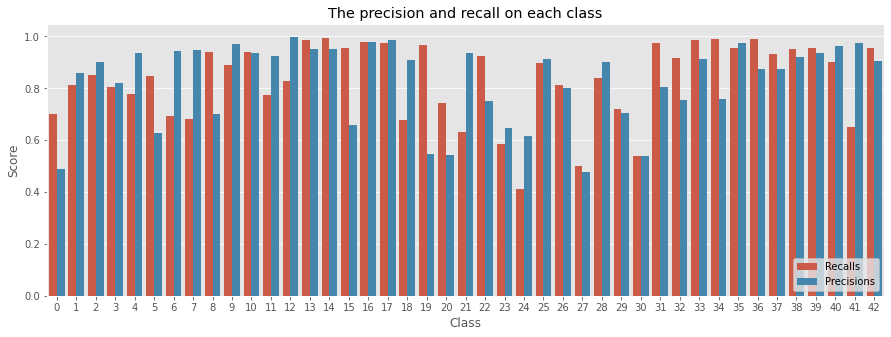

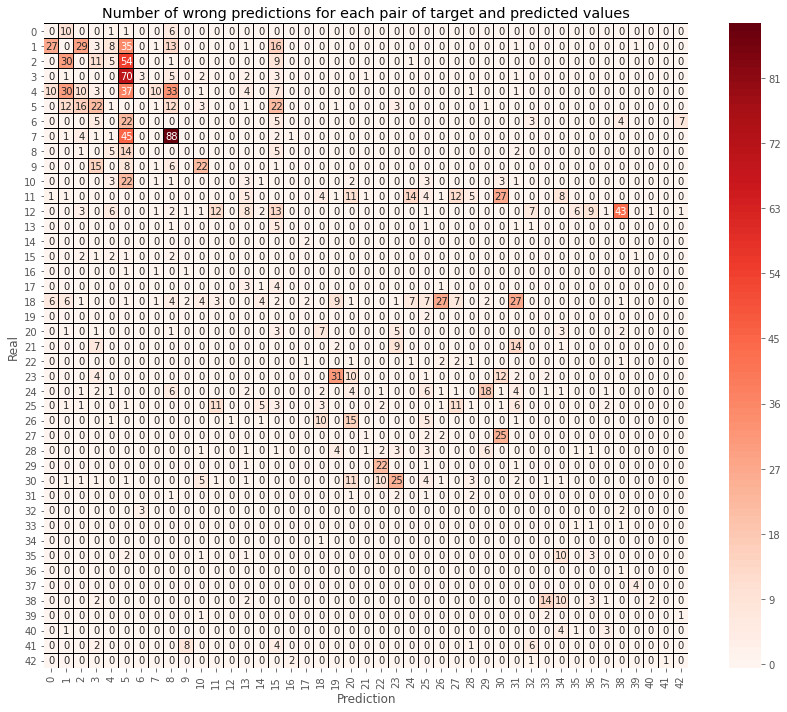

In [29]:
# Test scores:
y_preds = best_ann.predict_classes(x_test_vectorized)
plot_precision_recall(y_test, y_preds)
plot_wrong_predictions_heatmap(y_test, y_preds)

In [30]:
y_maps_probs = best_ann.predict(x_maps_vectorized)
y_maps_preds_idx = np.argmax(y_maps_probs, axis=1)
y_maps_preds = np.array(labels)[y_maps_preds_idx]
print('Accuracy:', accuracy_score(y_maps, y_maps_preds))

idx = [int(file.split('.')[0].split('test')[1]) for file in files]
pred_table = pd.DataFrame(
    np.c_[y_maps, y_maps_preds, np.round(np.max(y_maps_probs, axis=1), 3)],
    columns=['Real', 'Prediction', 'Probability'], index=idx)

def style(r):
    color = 'orange' if r['Real'] != r['Prediction'] else 'lightblue'
    return [f'background-color: {color}'] * len(r.values)

pred_table = pred_table.sort_index().style.apply(style, axis=1)
display(pred_table)

Accuracy: 0.7255813953488373


,Real,Prediction,Probability
1,Speed limit (20km/h),Speed limit (20km/h),0.997
2,Speed limit (20km/h),Yield,1.0
3,Speed limit (20km/h),Yield,0.929
4,Speed limit (20km/h),Yield,0.833
5,Speed limit (20km/h),Yield,0.885
6,Speed limit (30km/h),Speed limit (30km/h),0.677
7,Speed limit (30km/h),Speed limit (30km/h),0.939
8,Speed limit (30km/h),Yield,0.998
9,Speed limit (30km/h),Speed limit (50km/h),0.932
10,Speed limit (30km/h),Yield,0.993


Accuracy: 0.7255813953488373


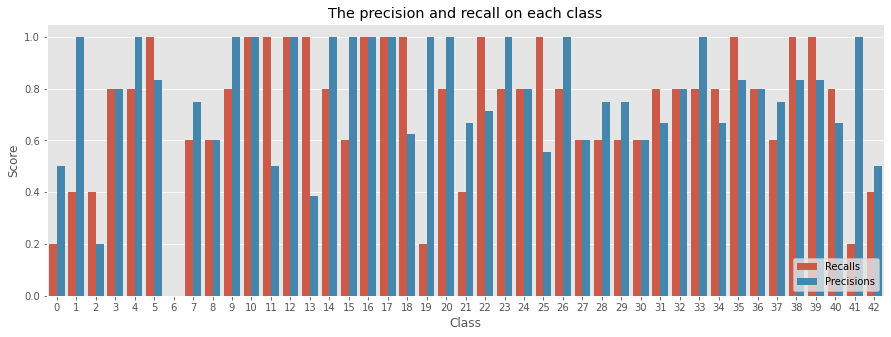

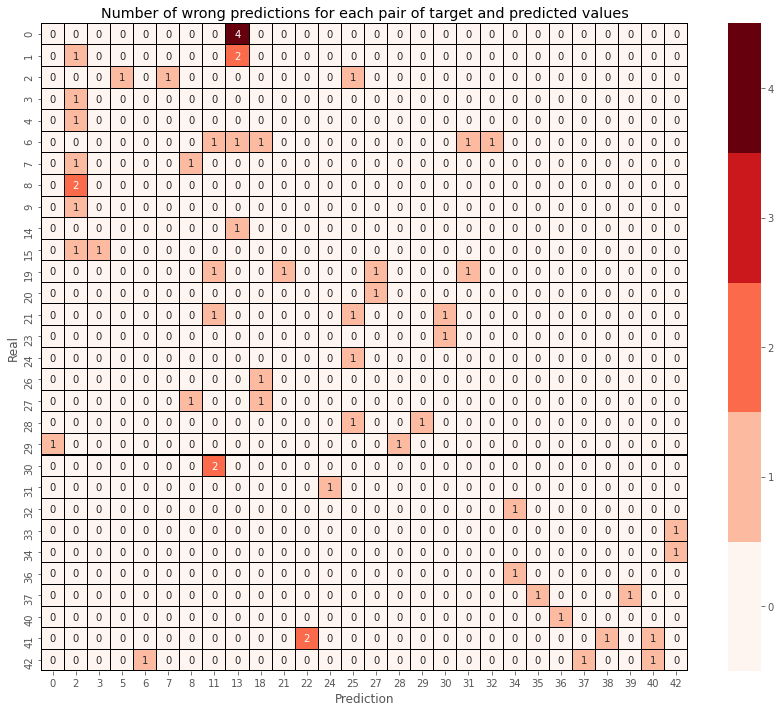

In [31]:
plot_precision_recall(y_maps, y_maps_preds)
plot_wrong_predictions_heatmap(y_maps, y_maps_preds)